In [2]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
! pip install geopandas
import geopandas as gpd
import numpy as np
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
! pip install hydrofunctions
import hydrofunctions as hf
import pickle
import matplotlib.font_manager as fm
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
fm.fontManager.ttflist += fm.createFontList(['thsarabunnew-webfont.ttf'])
matplotlib.rc('font', family='TH Sarabun New')
plt.rcParams.update({'font.size': 12})
from shapely.geometry import Polygon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.3 MB/s 
     |████████████████████████████████| 6.3 MB 41.1 MB/s 
     |████████████████████████████████| 16.7 MB 20.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 40 kB 3.3 MB/s 
--2022-06-23 23:02:18--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2022-06-23 23:02:19--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.github

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


## Earth Engine authenticate and initialize

In [3]:
!earthengine authenticate

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=p52mSW9Uh1brAkf1lMF_YP1f40Wo4nB7-gMGvksWqw0&tc=jpQ4WmNl76be-Xl5fX0VpaqIn4rHLZ0OoQhWycd_VAQ&cc=r9NwnTysMYuxHV6DRM34-AAM7ynGB-eoBfiPSM3ph_M

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWiNS8o5jzpZmv1IwkQL94kWyXz1i4jUIGv3-WPSwq-TIZKayMye044

Successfully saved authorization token.


In [4]:

# # here are the GEE declarations. 
import ee
ee.Initialize()

## Import information about study sites

In [5]:
# load in shapefile of gage locations and attributes
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/dwr_gages.zip'
gages = gpd.read_file(loc).to_crs(epsg = 4326)

# load in shapefile of watershed boundaries
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/dwr_watershed_boundaries.zip'
basin_outlines = gpd.read_file(loc).to_crs(epsg = 4326)

# merge data together
gage_info = gages.merge(basin_outlines,left_on='SITE_NO',
            right_on='SITE_NO')

# US state map from https://catalog.data.gov/dataset/tiger-line-shapefile-2017-nation-u-s-current-state-and-equivalent-national
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/state_outline.zip'
state_outline = gpd.read_file(loc).to_crs(epsg = 4326)
state_outline = state_outline[state_outline.STUSPS=='CA']

## Import SWE data from SNODAS
https://nsidc.org/data/g02158#:~:text=SNODAS%20is%20a%20modeling%20and,support%20hydrologic%20modeling%20and%20analysis

In [6]:
# import processed SNODAS data (basin means for each study site)
loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/snodas_basin_dwr.csv'
snodas_data = pd.read_csv(loc)
snodas_data['date'] = pd.to_datetime(snodas_data.date)
snodas_data = snodas_data.set_index('date').sort_index()

In [7]:
# process data from csv format to format with one column for each gage, rows are dates

swe_data = ''

for gage in snodas_data.sitenum.drop_duplicates():
  snowdat = snodas_data[snodas_data.sitenum==gage].drop(columns='sitenum')
  snowdat['wy'] = np.where(snowdat.index.month.isin([10,11,12]),
                           snowdat.index.year+1,snowdat.index.year)    
  if len(swe_data)==0:
    swe_data = snowdat[['swe']].rename(columns={'swe':gage}).dropna()
  else:
    swe_data = swe_data.merge(snowdat[['swe']].rename(columns={'swe':gage}).dropna(),
                              left_index=True,right_index=True).drop_duplicates()

In [8]:
# calculate melt rate as average decrease rate per day for all days
# when SWE decreased in a given year

swediff = swe_data.diff()
swediff['wy'] = np.where(swediff.index.month.isin([10,11,12]),
                          swediff.index.year+1,swediff.index.year)

for c in swediff.columns:
  swediff[c] = np.where(swediff[c]<0,0,swediff[c])
totalmelts = swediff.groupby('wy').sum()
swedays = swediff
for c in swedays.columns:
  if c !='wy':
    swedays[c] =  np.where(swedays[c]==0,0,1)
meltrates = totalmelts/swedays.groupby('wy').sum()
meltrates.to_csv('melt_rates.csv')

## Calculate spring streamflow

In [9]:
# get spring streamflow data from NWIS

springflow = {} # total spring streamflow
years = list(range(2001,2022))

for gage in gages.SITE_NO.values:
  flow_data = hf.NWIS(gage, 'dv', start_date = '2000-10-01',
                      end_date = '2021-10-01').df('00060')
  flow_data = flow_data*12**3*2.54**3/100**3*60*60*24
  # convert to depth (m/d)
  area = (gage_info[gage_info.SITE_NO==gage].SQMI*2.59*1000000).values[0] # are in m2
  flow_data = flow_data/area
  # convert to mm/day
  flow_data = flow_data*1000
  
  
  spring_streamflow = []
  for yr in years:
    try:
      spring_streamflow.append(sum(flow_data.loc[str(yr)+'-04-01':str(yr)+'-09-01'].values)[0])
    except:
      spring_streamflow.append(np.nan)
  springflow[gage] = spring_streamflow

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=11525500&startDT=2000-10-01&endDT=2021-10-01
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=11377100&startDT=2000-10-01&endDT=2021-10-01
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=11270900&startDT=2000-10-01&endDT=2021-10-01
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=11289650&startDT=2000-10-01&endDT=2021-10-01
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=11319500&startDT=2000-10-01&endDT=2021-10-01
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=11335000&startDT=2000-10-01&endDT=2021-10-01


In [10]:
def func(x,a,b):
  return a*x+b
from scipy import stats

# grab April 1 data from each year for each site
snow_data = swe_data[(swe_data.index.month==4) &
                     (swe_data.index.day==1)]


residuals_snodas = {} # residuals in SWE-Q relationship
snow_data_perc = {} # SWE percentiles
springflow_perc = {} # spring Q percentiles

Pdata=''
for gage in gages.SITE_NO.values:
  
  fig,axs = plt.subplots(1,2,figsize = (15,4))
  yvals =  springflow[gage][-1*len(snow_data):]
  snow_mm = snow_data[int(gage)]
  mask = (np.isfinite(yvals)) & (np.isfinite(snow_mm.values))

  # get percentiles (I don't think this is used)
  springflow_perc[gage] = [stats.percentileofscore(yvals, a, 'rank') for a in yvals]
  snow_perc = [stats.percentileofscore(snow_mm, a, 'rank') for a in snow_mm]
  snow_data_perc[gage] = snow_perc

  # mask by non-inf and non-nan
  snow_mm = snow_mm.values[mask]
  yvals = np.array(yvals)[mask]

  # fit a relationship between SWE and Q
  popt, pcov = curve_fit(func, snow_mm, yvals)
  residuals = np.array(yvals) - func(np.array(snow_mm), *popt)
  
  # plot the results
  ax = axs[0]
  ax.scatter(snow_mm,yvals)
  ax.set_xlabel('April 1 snowpack (mm)')
  ax.set_ylabel('Spring streamflow (april-june, mm)')
  ax.scatter(snow_mm[-1:],springflow[gage][-1:],
              c='firebrick')
  xvals = np.linspace(np.nanmin(snow_mm),np.nanmax(snow_mm))
  ax.plot(xvals,func(xvals,*popt),c='k',ls='--')

  ax.set_title(gage)
  ax.set_ylim(0,np.nanmax(springflow[gage])*1.1)

  ax = axs[1]
  ax.scatter(snow_data.index[mask],residuals)#/snow_mm)
  ax.set_xlabel('year')
  ax.set_ylabel('residual (mm)')
  # ax.set_ylim(-1,1)
  ax.axhline(0,ls='--',c='k')
  ax.scatter(snow_data.index.values[-1:],residuals[-1:]#/snow_mm[-1:]
             ,c='firebrick')
  residuals_snodas[gage] = np.where(np.isfinite(residuals),#/snow_mm),
                                    residuals,#/snow_mm,
                                    100)
  

## Get ET data from Earth Engine

In [11]:
# convert geopandas basin objects into geojson for Earth Engine

geos1 = gage_info.geometry_y.values
geos = []
for i in range(len(geos1)):
  try:
    geo_obj = ee.Geometry.Polygon(list(geos1[i].exterior.coords))
  except:
    geos1[i] = geos1[i][-1]
    geo_obj = ee.Geometry.Polygon(list(geos1[i].exterior.coords))
  geos.append(geo_obj)
names = gage_info.STATION_NM.values

start='2000-10-01'
stop='2021-10-01'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  if __name__ == '__main__':


In [12]:
# code adapted from David Dralle
# Flux is stored as 100*mm/day, and duration between samples is 8 days
multiplier = 8.0 
dataset = ee.ImageCollection("projects/pml_evapotranspiration/PML/OUTPUT/PML_V2_8day_v016");
scale = 0.01

# mapper for getting single ET raster for each timestep
def sumpml(image):
  # ET bands into one band
  temp = image.select('Es').add(image.select('Ec')).add(image.select('Ei')).multiply(scale)

  #get the first band of this new temporary image, rename it to 'ET', 
  #reproject it, and then multiply by multiplier
  temp = temp.select([0], ['ET']).reproject(
      crs='EPSG:4326',scale=10000
      ).multiply(multiplier)

  #temp should now be total ET in mm over the time window between images
  #assign the datetime stamp and the index from the original image
  temp = temp.set('system:time_start', image.get('system:time_start'))
  temp = temp.set('system:index', image.get('system:index'))
  return temp

#now, actually map the pml image collection w/ this function,
# in order to make a new combined ET image collection
et = ee.ImageCollection(dataset.map(sumpml).select('ET')).filter(ee.Filter.date(start, stop))
et = et.toBands()

In [13]:
# for each study basin, get basin-average ET, P

data = {}
for i,geo in enumerate(geos):
  ft = et.reduceRegion(ee.Reducer.mean(), geo, 10000)
  vals = ft.getInfo()
  dates = pd.to_datetime([item.split('_')[0] for item in list(vals)])
  etvals = [item for item in vals.values()]
  etdf = pd.DataFrame({'ET':etvals},index=dates)

  # first linearly interpolate to daily and then resample to monthly
  etdf = etdf.resample('M').sum()

  dataset = ee.ImageCollection("OREGONSTATE/PRISM/AN81m").filter(ee.Filter.date(start, stop))
  ppt = dataset.select('ppt').toBands()
  ft = ppt.reduceRegion(ee.Reducer.mean(), geo, 4000)
  vals = ft.getInfo()
  dates = pd.to_datetime([item.split('_')[0] for item in list(vals)],format='%Y%m')
  pptvals = [item for item in vals.values()]
  pptdf = pd.DataFrame({'P':pptvals},index=dates).resample('M').sum()
  
  # Combine
  df = pd.concat([etdf, pptdf],axis=1)
  # df['W'] = df[['P','ET']].min(axis=1)
  df['wy'] = [item.year if item.month<10 else item.year+1 for item in df.index]
  df['sumP'] = df.groupby('wy')['P'].cumsum()

  data[names[i]] = df



In [14]:
# # import modis data--this is very slow--just import finished data in next block

# # code below adapted from https://colab.research.google.com/github/google/earthengine-community/blob/master/tutorials/intro-to-python-api-guiattard/index.ipynb

modis = ee.ImageCollection('MODIS/006/MOD16A2')

# Initial date of interest (inclusive).
i_date = '2000-10-01'

# Final date of interest (exclusive).
f_date = '2021-10-01'

pet_modis = modis.select('PET').filterDate(i_date, f_date) #kg/m^2/8day
et_modis = modis.select('ET').filterDate(i_date, f_date) #kg/m^2/8day

scale = 1000  # scale in meters

def addTime(image) :
  return image.addBands(image.metadata('system:time_start'))

def reduceregions(image):
  meanET = image.reduceRegion(ee.Reducer.mean(),geo,1000)
  return image.set(meanET)

modis_data = {}

for i,geo in enumerate(geos):
  # et_geo = et_modis.filterBounds(geo).filterDate('2000-10-1','2021-10-01').select('ET')
  # et_region = et_geo.map(addTime).map(reduceregions)

  # etvals = et_region.aggregate_array('ET').getInfo()
  # timevals = et_region.aggregate_array('system:time_start').getInfo()
  # timevals = [ee.Date(t).format('YYYY-MM-dd').getInfo() for t in timevals]
  et_modis = et_modis.select('ET')
  et1 = et_modis.toBands()
  ft = et1.reduceRegion(ee.Reducer.mean(), geo, 10000)
  vals = ft.getInfo()
  dates = pd.to_datetime([item[:10].replace('_','-')
                                      for item in list(vals)])
  etvals = [item for item in vals.values()]
  etdf = pd.DataFrame({'ET':etvals},index=dates)
  etdf = etdf.resample('M').sum()
  etdf = etdf/8*1000/100**3*1000
  etdf = etdf.resample('M').sum()

  dataset = ee.ImageCollection("OREGONSTATE/PRISM/AN81m").filter(ee.Filter.date(start, stop))
  ppt = dataset.select('ppt').toBands()
  ft = ppt.reduceRegion(ee.Reducer.mean(), geo, 4000)
  vals = ft.getInfo()
  dates = pd.to_datetime([item.split('_')[0] for item in list(vals)],format='%Y%m')
  pptvals = [item for item in vals.values()]
  pptdf = pd.DataFrame({'P':pptvals},index=dates).resample('M').sum()
  
  # Combine
  df = pd.concat([etdf, pptdf],axis=1)
  # df['W'] = df[['P','ET']].min(axis=1)
  df['wy'] = [item.year if item.month<10 else item.year+1 for item in df.index]
  df['sumP'] = df.groupby('wy')['P'].cumsum()

#   # This is not where deficit is calculated in the code
#   deficit = [0]
#   counter = 0
#   # Wang-Erlandsson deficit calculation
#   for idx,row in df.iterrows():
#     A = row.ET - row.P
#     next = np.max([0, deficit[counter] + A])
#     deficit.append(next)
#     counter = counter + 1
#   df['D'] = deficit[1:]
  modis_data[names[i]] = df

import pickle
output = open('modis_data.pkl', 'wb')
pickle.dump(modis_data,output)
from google.colab import files
files.download('modis_data.pkl')

for key in modis_data.keys():
  sitenum = gages[gages.STATION_NM==key].SITE_NO.values[0]
  # modis_data[key].to_csv('modis_data_'+sitenum+'.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# import MODIS data for each site, save in dictionary

# base_loc = 'https://raw.githubusercontent.com/lapidesd/CA_missing_freshet/main/Data/MODIS_and_PRISM_data/modis_data_'

# modis_data = {key:0 for key in gages.STATION_NM.values}

# for site in gages.STATION_NM.values:
#   sitenum = gages[gages.STATION_NM==site].SITE_NO.values[0]
#   site_modis = pd.read_csv(base_loc+sitenum+'.csv')
#   site_modis['Unnamed: 0'] = pd.to_datetime(site_modis['Unnamed: 0'])
#   site_modis = site_modis.set_index('Unnamed: 0')
#   modis_data[site] = site_modis

In [16]:
# calculate parameters for bias-correcting MODIS data based on PML V2

def func(modis,a,b):
  return a*modis+b

r2vals=[]
modis_correct_params = {}
for site in gages.STATION_NM.values:
  fig, ax = plt.subplots(1,2,figsize = (12,6))

  # combine MODIS and PML ET data into single dataframe
  pml = data[site][['ET']].rename(columns={'ET':'pml'})
  modis = modis_data[site][['ET']].rename(columns={'ET':'modis'})
  merged = pml.merge(modis,left_index=True,
                     right_index=True,how='inner').dropna()

  # find a linear fit between PML and MODIS
  popt, pcov = curve_fit(func, merged.modis, merged.pml)
  xvals = np.linspace(0,max(merged.pml))
  ypredict = func(xvals,*popt)

  # plot results
  ax1=ax[0]
  merged['wy'] = np.where(merged.index.month.isin([10,11,12]),
                          merged.index.year+1,merged.index.year)
  merged_spring = merged[merged.index.month.isin([4,5,6,7])].groupby('wy').sum()
  ax1.plot(merged_spring.modis,label='Modis')
  ax1.plot(merged_spring.pml,label='pml')
  ax1.legend()
  ax1.set_ylabel('Spring ET (mm)')

  ax0=ax[1]
  ax0.plot(xvals, ypredict)
  ax0.scatter(merged.modis,merged.pml)
  ax0.set_xlabel('MODIS')
  ax0.set_ylabel('PML')
  ax0.set_title(site)

  # find R2 value
  residuals = merged.pml - func(merged.modis, *popt)
  ss_res = np.sum(residuals**2)
  ss_tot = np.sum((merged.pml-np.mean(merged.pml))**2)
  r_squared = 1 - (ss_res / ss_tot)
  std = np.std(residuals)
  r2vals.append(r_squared)

  # save parameters
  modis_correct_params[site] = popt

In [17]:
# print median R2 value for bias-correcting linear fit
np.nanpercentile(r2vals,50)

0.5659910824507122

In [18]:
etdf

,ET
2001-01-31,50.522326
2001-02-28,39.269989
2001-03-31,72.959089
2001-04-30,63.583839
2001-05-31,104.078015
...,...
2021-05-31,98.305178
2021-06-30,65.614210
2021-07-31,31.712420
2021-08-31,35.861119


In [19]:
# since PML dataset ends in 2020, extend with bias-corrected MODIS

for i in range(len(gages)):
  
  # get MODIS data
  site = gages.STATION_NM.values[i]
  sitedata = modis_data[site]
  etdf = sitedata[['ET','wy']]
  etdf = etdf.resample('M').sum()
  
  # get PML data
  sitedata_pml = data[site]
  etdf_pml = sitedata_pml[['ET','wy']].resample('M').sum()
  etdf_pml = etdf_pml[etdf_pml.ET>0]
  etdf = etdf.reset_index()[~(etdf.reset_index()['index'].isin(etdf_pml.index))]

  # use parameters from linear fit (above) to extend PML using bias-corrected MODIS
  etdf['ET'] = func(etdf.ET,*modis_correct_params[site])
  etdf = etdf.set_index('index')
  df = pd.concat([etdf_pml,etdf])
  wys = df.wy.drop_duplicates()
  ets = []
  for yr in wys:
    ets.append(df.loc['04-01-'+str(yr):'07-01-'+str(yr)].ET.sum())
  data[site]['ET_with_modis'] = df.ET

  # plot resulting ET timeseries
  fig,axs = plt.subplots(1,2,figsize = (12,3))
  ax=axs[0]
  ax.plot(df.ET)
  ax.set_ylabel('PML extend with bias-corrected MODIS')
  ax.set_title(site)

  ax=axs[1]
  df_spring = df[df.index.month.isin([4,5,6,7])].groupby('wy').sum()
  wy_P = data[site].groupby('wy').sum().P
  ET_P = df_spring.values.flatten()/data[site].groupby('wy').sum().P.values.flatten()
  ax.plot(df_spring.index,ET_P)
  ax.set_ylabel('Spring ET/WY P')

## Import soil storage capacity information

In [20]:
# soil storage capacity
Ssoil = ee.Image('users/ericamccormick/20_RockMoisture/products/gNATSGO/Ssoil_500m')
soildepth = {site:0 for site in gages.SITE_NO.values}
for i in range(len(soildepth.keys())):
  ft = Ssoil.reduceRegion(ee.Reducer.mean(), geos[i], 100)
  soildepth[gages.SITE_NO.values[i]] = ft.getInfo()

In [21]:
# root zone storage capacity
Sr = ee.Image('users/ericamccormick/20_RockMoisture/deficit/root-zone/Sr2003_2017_Mask')
Srz = {site:0 for site in gages.SITE_NO.values}
for i in range(len(Srz.keys())):
  ft = Sr.reduceRegion(ee.Reducer.mean(), geos[i], 100)
  Srz[gages.SITE_NO.values[i]] = ft.getInfo()
Srz

{'11270900': {'S_R_snow_corr': 631.8903482818082},
 '11289650': {'S_R_snow_corr': 435.5146610095138},
 '11319500': {'S_R_snow_corr': 378.26942630257815},
 '11335000': {'S_R_snow_corr': 456.3574315488715},
 '11377100': {'S_R_snow_corr': 384.33740167546426},
 '11525500': {'S_R_snow_corr': 382.88597448368785}}

## Calculate deficit from mass balance

In [22]:
# Wang-Erlandsson storage deficit mass balance approach 
# including snow from SNODAS

for site in gages.STATION_NM.values:
  gageid = gages[gages.STATION_NM==site].SITE_NO.values[0]
  
  temp = data[site]
  snowdat = swe_data[[int(gageid)]].resample('M').last().rename(columns={int(gageid):'snodas'}).fillna(0)
  try:
    temp = temp.drop(columns=['snodas',])
  except:
    print('')
  temp = temp.merge(snowdat,left_index=True,right_index=True,
                    how='left')
  
  # find snowfall as all positive changes in SWE
  # and snowmelt is all negative changes in SWE
  snowchange = temp.snodas.diff()
  snowchange = np.where(np.isnan(snowchange),0,snowchange)

  # calculate total water inputs as P (take out snowfall, add in snowmelt)
  P_adj = temp.P-snowchange

  df = temp
  deficit = [0]
  counter = 0
  gage = gageid

  # deficit calculation
  for idx,row in df.fillna(0).iterrows():
    if np.isnan(row.snodas):
      deficit.append(0)
      counter += 1
    else:
      A = row.ET_with_modis - P_adj.loc[idx] 
      next = np.max([0, deficit[counter] + A])
      deficit.append(next)
      counter = counter + 1

  df['D_snodas'] = deficit[1:]

  data[site] = df

In [23]:
# plot running deficit calculation at all sites

f,axs = plt.subplots(3,5,figsize=(20,5))#,sharey=True)
axs[0][0].set_ylabel('Deficit (mm)')
axs[1][0].set_ylabel('Deficit (mm)')
# axs[2][0].set_ylabel('Deficit (mm)')
axlab = [[0,0],[0,1],[0,2],[0,3],[0,4],
         [1,0],[1,1],[1,2],[1,3],[1,4],
         [2,0],[2,1],[2,2],[2,3],[2,4],
         [3,0],[3,1],[3,2],[3,3],[3,4],
         [4,0],[4,1],[4,2],[4,3],
         [5,0],[5,1],[5,2],[5,3],
         [6,0],[6,1],[6,2],[6,3],
         ]
for i in range(len(gages)):
  ax = axs[axlab[i][0]][axlab[i][1]]
  temp = data[gages.STATION_NM.values[i]]
  temp.D_snodas.plot(ax=ax,label=None)
  # ax.scatter(temp[temp.index.month==10].index,temp[temp.index.month==10].D_snodas,
  #            c='firebrick',label = 'October deficit')
  # ax.scatter(temp[temp.index.month==4].index,temp[temp.index.month==4].D_snodas,
  #            c='goldenrod',label = 'Min. deficit')
  if i==0:
    ax.legend()
  # temp[temp.index.month==4].D_snodas.plot(ax=ax,c='k',lw=1,label=None)
  temp['wy_shift'] = temp.index.year+1
  maxDates = temp.loc[temp[temp.index.month.isin([8,9,10,11,12,])].groupby("wy_shift")["D_snodas"].idxmax()].iloc[1:]
  minDates = temp.loc[temp[temp.index.month.isin([1,2,3,4,5,6])].groupby("wy")["D_snodas"].idxmin()].iloc[1:]
  maxDates.D_snodas.plot(ax=ax,c='k',lw=1,label=None)
  minDates.D_snodas.plot(ax=ax,c='k',lw=1,label=None)
  ax.scatter(maxDates.index,maxDates.D_snodas,c='firebrick',label='Max. deficit')
  ax.scatter(minDates.index,minDates.D_snodas,c='goldenrod',label='Min. deficit')
  ax.set_title(gages.SITE_NO.values[i])
  ax.axhline(soildepth[gages.SITE_NO.values[i]]['b1'],c='k',ls='--')
f.tight_layout()

## Aggregate all data for all sites

In [24]:
# calculate snowfall by using a temperature threshold to decide
# if precip is snow or rain
# this matches well with just using the snow data to determine if
# snow accumulated or not, so we will just use that
for site in gages.SITE_NO.values:
  sitenm = gages[gages.SITE_NO==str(site)].STATION_NM.values[0]
  df = data[sitenm]
  # temp = modisT[[str(site)]].rename(columns={str(site):'modisT'})
  # df = df.merge(temp,left_index=True,right_index=True)
  # df['snowfall_t'] = np.where(df.modisT<=0,df.P,0)
  data[sitenm] = df


In [25]:
# save summary data for each study site

def fun(SWE,a,b):
  return a*SWE+b
def fun1(X,a,b,c):
  # print(X)
  SWE,D = X
  return a*SWE+b*D+c

fitparams_swe = {s:0 for s in gages.SITE_NO.values}
fitparams_sweD = {s:0 for s in gages.SITE_NO.values}
Q2021 = {s:0 for s in gages.SITE_NO.values}

for key in gages.STATION_NM.values:
  sitenum = gages[gages.STATION_NM==key].SITE_NO.values[0]
  df = data[key]
  wyP = df.groupby('wy').sum().P.values.flatten()
  # df['Temp'] = modisT[sitenum]
  aprSWE = df[df.index.month==3].snodas
  df['snowfall'] = df.snodas.fillna(method='bfill')
  df['snowfall'] = df.snowfall.diff()
  df['snowfall'] = np.where(df.snowfall<0,0,df.snowfall)
  df['snowfall'] = df.snowfall.fillna(value=0)
  df['P_adj'] = df.P-df.snowfall
  df['P_adj'] = np.where(df.P_adj<0,0,df.P_adj)
  df['spring_rain'] = np.where(df.index.month.isin([1,2,3,8,9,10,11,12]),
                               0,df.P_adj)
  df['winter_P'] = np.where(df.index.month.isin([10,11,12,1,2,3]),
                            df.P,0)
  winter_rain = df[df.index.month.isin([10,11,12,1,2,3])].groupby('wy').sum()
  winter_rain = winter_rain.P-winter_rain.snowfall
  wy_precip_adj = df.groupby('wy').sum().P_adj.values
  wys = df.wy.drop_duplicates().values.flatten()
  wySWE = df.groupby('wy').sum().snowfall.values.flatten()
  # wySWE_t = df.groupby('wy').sum().snowfall_t.values.flatten()
  wyET = df[df.index.month.isin([4,5,6,7])].groupby('wy').sum().ET.values.flatten()
  winterET = df[df.index.month.isin([10,11,12,1,2,3])].groupby('wy').sum().ET.values.flatten()
  octD = df[df.index.month==10].D_snodas.values.flatten()
  aprD = df[df.index.month==4].D_snodas.values.flatten()
  df['wy_shift'] = np.where(df.index.isin([9,10,11,12]),
                                df.index.year+1,df.index.year)
  maxD = df[df.index.month.isin([8,9,10,11,12])].groupby('wy_shift').max().D_snodas.values.flatten()[1:]
  minD = df[df.index.month.isin([8,9,10,11,12])].groupby('wy_shift').min().D_snodas.values.flatten()[1:]

  site_wy_info = pd.DataFrame.from_dict({'wy':wys,
                                            'P':wyP,
                                            'adjP':wy_precip_adj,
                                            'spring_rain':df.groupby('wy').sum().spring_rain.values,
                                            'winter_P':df.groupby('wy').sum().winter_P.values,
                                            'winter_rain':winter_rain,
                                            # 'snow_frac':snow_fraction[sitenum].values,
                                            'total_swe':wySWE,
                                            # 'snowfall_t':wySWE_t,
                                            'springET':wyET,
                                            'AprSWE': aprSWE.values.flatten(),
                                            'winterET':winterET,
                                            'maxDeficit':maxD,
                                            'minDeficit':minD,
                                            'octDeficit':octD,
                                            'aprDeficit':aprD})
  
  site_sub = site_wy_info[['AprSWE','octDeficit','winter_rain','winter_P']].iloc[3:]

  popt,pcov = curve_fit(fun1,(site_sub.AprSWE,site_sub.winter_rain),
                        springflow[sitenum][-len(site_sub):])
  yfit = fun1((site_sub.AprSWE,site_sub.winter_rain),*popt)
  fitparams_swe[sitenum] = [popt,yfit.values[-1]]

  popt,pcov = curve_fit(fun1,(site_sub.AprSWE.values,site_sub.octDeficit.values/site_sub.winter_P.values),
                        springflow[sitenum][-len(site_sub):])
  yfit = fun1((site_sub.AprSWE,site_sub.octDeficit/site_sub.winter_P.values),*popt)
  fitparams_sweD[sitenum] = [popt,yfit.values[-1]]
  Q2021[sitenum] = springflow[sitenum][-1]
  
  plt.scatter(springflow[sitenum][-len(site_sub):],yfit)
  plt.scatter([(springflow[sitenum][-len(site_sub):])[-1]],[yfit.values[-1]],c='firebrick')
  plt.title(key)
  plt.plot([0,max(yfit)],[0,max(yfit)],
           c='k',ls='--')
  plt.show()

  # site_wy_info.to_csv('all_deficit_data_'+str(sitenum)+'.csv')

## Test potential improvement of model by adding Oct 1 D

In [26]:
Q2021,fitparams_swe,fitparams_sweD

totflow = sum([Q2021[key] for key in Q2021.keys()])
swe_err = []
swed_err = []
swe_err_tot = []
swed_err_tot = []

for s in Q2021.keys():
  swe_err.append(-(Q2021[s]-fitparams_swe[s][1])/Q2021[s]*100)
  swed_err.append(-(Q2021[s]-fitparams_sweD[s][1])/Q2021[s]*100)
  swe_err_tot.append(-(Q2021[s]-fitparams_swe[s][1])/totflow*100)
  swed_err_tot.append(-(Q2021[s]-fitparams_sweD[s][1])/totflow*100)

In [27]:
sum(swe_err_tot),sum(swed_err_tot)

(34.302583206372304, 2.573889986243001)

In [28]:
np.nanmedian(swe_err),np.nanmedian(swed_err)

(18.15119369346754, 1.8756043938916986)

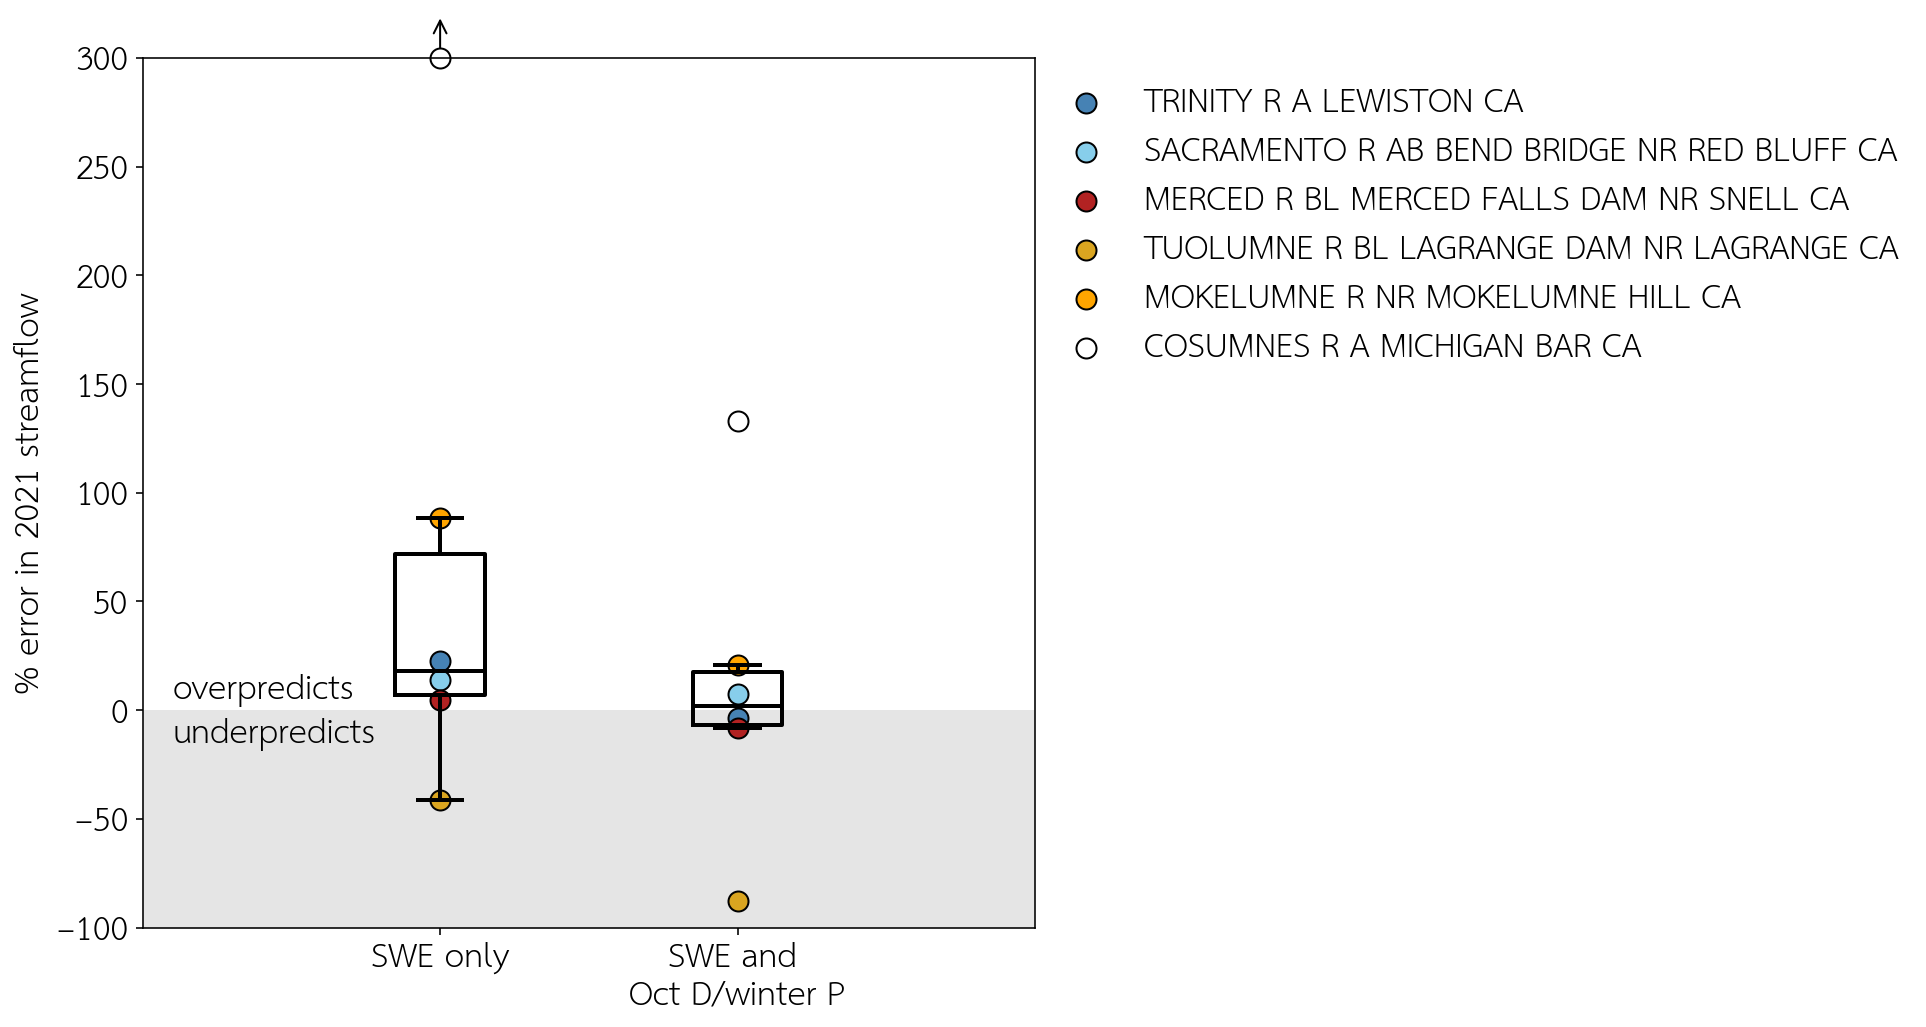

In [29]:
%matplotlib inline
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(1,figsize = (8,8))
size = 100

colors = ['steelblue','skyblue','firebrick','goldenrod',
          'orange','white']
sitenames = gages.STATION_NM.values

for i in range(len(swed_err)):
  ax.scatter([0],swe_err[i],s=size,
           edgecolor = 'k',c=colors[i],label=sitenames[i])
ax.boxplot(swe_err,positions=[0],
           boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0, color='black'),
           capprops = dict(linewidth=2.0, color='black'),
           showfliers=False)
ax.scatter([0],[300],s=size,edgecolor = 'k',c=colors[i],label=None,
           clip_on=False)
ax.annotate('',xy = (0,300),
            xytext = (0,320),
            arrowprops = dict(arrowstyle="<-",
                            connectionstyle="arc3"),
            clip_on=False, zorder = -1
            )

for i in range(len(swed_err)):
  ax.scatter([0.5],swed_err[i],s=size,
           edgecolor = 'k',c=colors[i],label=None)
ax.boxplot(swed_err,positions=[0.5],
           boxprops= dict(linewidth=2.0, color='black'),
           whiskerprops = dict(linewidth=2.0, color='black'),
           medianprops = dict(linewidth=2.0, color='black'),
           capprops = dict(linewidth=2.0, color='black'),
           showfliers=False)

ax.axhspan(-150,0,facecolor='k',alpha=0.1,zorder=-1)
ax.set_ylim(-100,300)
ax.set_xticklabels(['SWE only','SWE and \nOct D/winter P'])
ax.set_ylabel('% error in 2021 streamflow')

ax.legend(loc='upper right',bbox_to_anchor = (2,1),frameon=False)

ax.text(-0.45,5,'overpredicts')
ax.text(-0.45,-15,'underpredicts')

plt.savefig('model_performance_dwr_sites.png',format='png',bbox_inches='tight',
            dpi=300)

In [30]:
swe_err

[22.505478595053738,
 13.796908791881343,
 4.616078855676496,
 -41.14869425975382,
 88.53747344168535,
 405.624636877257]

In [32]:
swed_err

[-3.8203191696367695,
 7.571527957420167,
 -8.064830092214452,
 -87.88956699195506,
 20.650833963757613,
 133.0290988001507]

In [31]:
sitenames

array(['TRINITY R A LEWISTON CA',
       'SACRAMENTO R AB BEND BRIDGE NR RED BLUFF CA',
       'MERCED R BL MERCED FALLS DAM NR SNELL CA',
       'TUOLUMNE R BL LAGRANGE DAM NR LAGRANGE CA',
       'MOKELUMNE R NR MOKELUMNE HILL CA', 'COSUMNES R A MICHIGAN BAR CA'],
      dtype=object)

In [ ]:
gages

,FID_SITES,AGENCY_CD,SITE_NO,STATION_NM,STATE_CD,STATE,SITESTATUS,DA_SQ_MILE,LON_SITE,LAT_SITE,...,MAX_,AVE,STDEV,GOTQ,NWISWEB,HUC,HUC_REG,SUBREGIONS,ACCOUNTING,geometry
0,14280,USGS,11525500,TRINITY R A LEWISTON CA,06,CA,A,719.0,-122.803634,40.719312,...,38700.0,1121.288,1840.691,1,http://waterdata.usgs.gov/nwis/nwisman/?site_n...,18010211,18,1801,180102,POINT (-122.80345 40.71984)
1,13451,USGS,11377100,SACRAMENTO R AB BEND BRIDGE NR RED BLUFF CA,06,CA,A,8900.0,-122.186664,40.288488,...,261000.0,12025.307,13005.531,1,http://waterdata.usgs.gov/nwis/nwisman/?site_n...,18020101,18,1802,180201,POINT (-122.18705 40.28866)
2,8609,USGS,11270900,MERCED R BL MERCED FALLS DAM NR SNELL CA,06,CA,A,1061.0,-120.332411,37.521603,...,37200.0,1327.526,1601.183,1,http://waterdata.usgs.gov/nwis/nwisman/?site_n...,18040002,18,1804,180400,POINT (-120.33258 37.52176)
3,8766,USGS,11289650,TUOLUMNE R BL LAGRANGE DAM NR LAGRANGE CA,06,CA,A,1538.0,-120.442139,37.666321,...,50100.0,978.543,1874.442,1,http://waterdata.usgs.gov/nwis/nwisman/?site_n...,18040002,18,1804,180400,POINT (-120.44251 37.66640)
4,9700,USGS,11319500,MOKELUMNE R NR MOKELUMNE HILL CA,06,CA,A,544.0,-120.720211,38.312693,...,31300.0,984.309,1131.653,1,http://waterdata.usgs.gov/nwis/nwisman/?site_n...,18040012,18,1804,180400,POINT (-120.72018 38.31263)
5,9953,USGS,11335000,COSUMNES R A MICHIGAN BAR CA,06,CA,A,536.0,-121.045221,38.500186,...,61600.0,493.170,1221.584,1,http://waterdata.usgs.gov/nwis/nwisman/?site_n...,18040013,18,1804,180400,POINT (-121.04523 38.50027)
